In [ ]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import os
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test')

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
#     print(features)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return features

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image,encoder):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


INITIALIZING THE INPUT

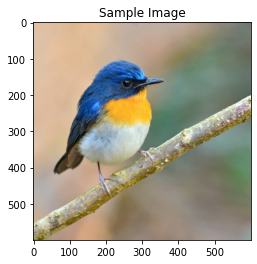

In [6]:
file_name = 'bird.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)

IMPORTING THE MODEL

In [7]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model_tree_saliency import EncoderCNN_b ,DecoderRNN_b

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN_b(embed_size)
encoder.eval()
decoder = DecoderRNN_b(embed_size, hidden_size, vocab_size)
decoder.eval()
print(os.getcwd())
address = os.path.join(os.getcwd(),'models', encoder_file)
print(address)
# Load the trained weights.
encoder.load_state_dict(torch.load(address))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

# Move models to GPU if CUDA is available.      
encoder.to(device)
decoder.to(device)
# encoder.zero_grad()
# decoder.zero_grad()

# print(clean_sentence(caption))
from lstm_saliency_tree import Saliency

target_layer = [*encoder.children()][0][-2][0].conv1
saliency_object = Saliency(encoder,decoder,target_layer)
cap_sal_dict = saliency_object(input_image.reshape(1,3,224,224).to('cuda'))


Vocabulary successfully loaded from vocab.pkl file!
9 2048
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\models\encoder-1.pkl
Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


C:\Users\ACER\anaconda3\envs\deepLearning\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [9]:
from utils import visualize_cam
from datetime import datetime
## function to generate the captions for all the timestamps
def create_saliency_map(caption,saliency_maps):
    images_=[]
    for saliency_map in saliency_maps:
        saliency_map.cpu()
        heatmap_t, result_t = visualize_cam(saliency_map.cpu(),input_image.cpu())
        images_.append(torch.stack([input_image.squeeze().cpu(),heatmap_t,result_t],0))
    images = make_grid(torch.cat(images_,0),nrow=3)
    
    output_dir = 'outputs'
    os.makedirs(output_dir, exist_ok=True)
    now = datetime.now()
    dt_string = now.strftime("%H_%M_%S")
    output_name = caption.replace(" ", "_") + dt_string + "_lstm_output.JPEG"
    output_path = os.path.join(output_dir, output_name)
    save_image(images, output_path)

In [10]:
for keys in cap_sal_dict:
#     create_saliency_map(keys,cap_sal_dict[keys])
    print(keys)

a white bird sitting on top of a branch . 
a white bird sitting on top of a tree branch . 
a white bird sitting on top of a wooden table . 
a small bird sitting on a branch in a tree . 
a small bird is perched on a branch 


ADDING ALL THE SALIENCY MAPS GENERATED FOR ONE CAPTION

In [7]:
print(keys)
saliency_maps = cap_sal_dict[keys]
result = torch.zeros([1,1,224,224]).to(device)
# print(result)
images = []
for s_map in saliency_maps:
#     s_map = s_map/len(keys.split())
    result = result + s_map
# result = result/len(keys.split())
heatmap_t, result_t = visualize_cam(result.cpu(),input_image.cpu())
added_image = torch.stack([input_image.squeeze().cpu(),heatmap_t,result_t],0)
images.append(added_image)
# print(added_image.size())
images_ = make_grid(torch.cat(images,0),nrow=3)
output_name =  keys.replace(" ", "_")+file_name
# save_image(images_, os.path.join("outputs", output_name))

NameError: name 'keys' is not defined

CREATING SCORE REPORTS

In [17]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model_tree_saliency_new import EncoderCNN_b ,DecoderRNN_b

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN_b(embed_size)
encoder.eval()
decoder = DecoderRNN_b(embed_size, hidden_size, vocab_size)
decoder.eval()
print(os.getcwd())
address = os.path.join(os.getcwd(),'models', encoder_file)
print(address)
# Load the trained weights.
encoder.load_state_dict(torch.load(address))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

# Move models to GPU if CUDA is available.      
encoder.to(device)
decoder.to(device)
# encoder.zero_grad()
# decoder.zero_grad()

# print(clean_sentence(caption))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9 2048
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\models\encoder-1.pkl


DecoderRNN_b(
  (word_embeddings): Embedding(10321, 512)
  (embed): Embedding(10321, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=10321, bias=True)
)

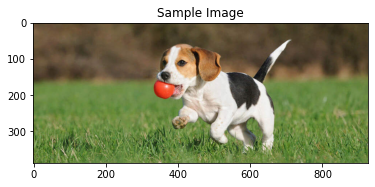

Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [78]:
from lstm_saliency_tree_new import Saliency

file_name = 'dog.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)

target_layer = [*encoder.children()][0][-2][0].conv1
saliency_object = Saliency(encoder,decoder,target_layer)
cap_sal_dict, cap_score_dict,cap_bs_score_dict = saliency_object(input_image.reshape(1,3,224,224).to('cuda'))

In [79]:
for keys in cap_bs_score_dict:
    print(keys)

a dog is chewing on a frisbee in the grass . 
a dog is sitting on a wooden bench . 
a dog is sitting on a chair with a frisbee . 
a dog is sitting on a white chair . 
a dog is sitting on a white bench . 
a dog is playing with a frisbee in the grass . 
a dog that is standing in the grass . 
a dog that is sitting on a chair . 
a dog that is sitting on a grass field . 
a dog that is sitting on a toilet . 
a brown and white dog with a frisbee in its mouth . 
a brown and white dog is sitting on a grass field . 
a brown and white dog is sitting on a green lawn chair . 
a brown and white dog standing on a lush green field . 
a brown and white dog standing on a grassy field . 
a brown and white dog standing next to a frisbee . 


In [12]:
keys,cap_bs_score_dict[keys].item(),len(keys.split()),cap_bs_score_dict[keys].item()/len(keys.split())

13.0

In [31]:
cap_bs_score_dict[0]

{'a white bird sitting on top of a branch . ': tensor([137.3163], device='cuda:0', grad_fn=<AddBackward0>),
 'a white bird sitting on top of a tree branch . ': tensor([150.4333], device='cuda:0', grad_fn=<AddBackward0>),
 'a white bird sitting on top of a wooden table . ': tensor([147.6671], device='cuda:0', grad_fn=<AddBackward0>),
 'a small bird sitting on a branch in a tree . ': tensor([143.5631], device='cuda:0', grad_fn=<AddBackward0>),
 'a small bird is perched on a branch ': tensor([123.0805], device='cuda:0', grad_fn=<AddBackward0>)}

In [29]:
# %
from PIL import Image, ImageDraw, ImageFont

img = Image.open('images/bird.jpg')
d1 = ImageDraw.Draw(img)
myFont = ImageFont.truetype('FreeMono.ttf', 20)
d1.text((img.width/5,img.height - 30), 'a white bird sitting on top of a branch . ', font=myFont, fill =(0, 0, 0))
img.show()
img.save("images/image_text.jpg")

In [55]:
import cv2

image = cv2.imread('images/bird.jpg')
overlay = image.copy()
# Rectangle parameters
x,y,c = image.shape
print(x,y,c)
w, h = 100, 50  
# A filled rectangle
cv2.rectangle(overlay, (0, 0), (w/2, h/2), (0, 0, 0), -1)  
  
alpha = 0  # Transparency factor.
  
# Following line overlays transparent rectangle
# over the image
image_new = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
  
plt.imshow(image_new)

600 600 3


TypeError: function takes exactly 4 arguments (2 given)

600

In [83]:
import pandas as pd

def create_score_report(caption, score_values):
#     print(values)
    word_list = []
    length = len(caption.split()) + 1
    for t in range(0,length):
        predicted_scores = score_values[t].values[0].tolist()
        predicted_indices = score_values[t].indices[0].tolist()
#         print(predicted_indices)
        for w in range(0,5):
#             print()
            word = data_loader.dataset.vocab.idx2word[predicted_indices[w]]
            if word not in word_list:
                word_list.append(word)
#     print(len(word_list))
#     word_indx_list = [0]
    word_indx_list = []
    for word in word_list:
        word_indx_list.append(data_loader.dataset.vocab.word2idx[word])
#     print(len(word_indx_list))
    
    myDataFrame = pd.DataFrame(columns = word_list)
    
    for t in range(0,length):
        predicted_scores = score_values[t].values[0].tolist()
#         print(predicted_scores)
        predicted_indices = score_values[t].indices[0].tolist()
#         print(predicted_indices)
        for w_index in word_indx_list:
#             print(w_index)
            if w_index in predicted_indices:
                index = predicted_indices.index(w_index)
                score = predicted_scores[index]
#                 print(index,score)
            else:
                score = 0
#             print(w_index)
            column = data_loader.dataset.vocab.idx2word[w_index]
#             print(t,column)
            myDataFrame.loc[t,column] = score
#     print(myDataFrame.transpose())
    return(myDataFrame)

def save_reports(caption, DataFrame,file_name):
    file_name = os.path.splitext(file_name)[0]
    path = os.path.join(os.getcwd()+"\\Reports\\"+file_name)
#     print(path)
    if not (os.path.exists(path)):
        os.makedirs(path) 
    file_path = os.path.join(path,caption.replace(" ","_"))
#     print(file_path)
    DataFrame.transpose().to_csv(file_path+".csv")
    

In [261]:
caption = list(cap_score_dict.keys())[0]
# Report_dataframe = create_score_report(caption, cap_score_dict[caption])
# save_reports(caption,Report_dataframe, file_name)

C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\Reports\girl_umbrella
C:\Users\ACER\PycharmProjects\eXplainable_Image_Captioning\Reports\girl_umbrella\a_woman_holding_a_umbrella_in_front_of_a_group_of_people_._


In [81]:
os.path.splitext(file_name)[0]

'dog'

In [84]:
for caption in cap_score_dict.keys():
    print(caption)
    Report_dataframe = create_score_report(caption, cap_score_dict[caption])
    save_reports(caption,Report_dataframe, file_name)

a dog is chewing on a frisbee in the grass . 
a dog is sitting on a wooden bench . 
a dog is sitting on a chair with a frisbee . 
a dog is sitting on a white chair . 
a dog is sitting on a white bench . 
a dog is playing with a frisbee in the grass . 
a dog that is standing in the grass . 
a dog that is sitting on a chair . 
a dog that is sitting on a grass field . 
a dog that is sitting on a toilet . 
a brown and white dog with a frisbee in its mouth . 
a brown and white dog is sitting on a grass field . 
a brown and white dog is sitting on a green lawn chair . 
a brown and white dog standing on a lush green field . 
a brown and white dog standing on a grassy field . 
a brown and white dog standing next to a frisbee . 


In [264]:
os.path.exists(path)

True